**SHOR'S ALGORITHM**
Shor's Algorithm helps to factorize large numbers in polynomial time complexity w.r.t log(N) whereas classical algorithms take exponential time wrt log(N)

The classical part of this algorithm is based on some simple propertries of modular aritmetic like Fermatt's Little Theorem which states that we can find a number r for every number a coprime with N such that a^r is 1 modulo N. Hence, here we are going to fasctorise 15 by choosing a=7 for which this period is 4(r).

In [1]:
!pip install qiskit
!pip install qiskit pylatexenc --quiet
!pipo install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
/bin/bash: line 1: pipo: command not found


In [6]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 76.8 MB/s eta 0:00:00


In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit.circuit import Gate
import numpy as np
from fractions import Fraction
import math

/tmp/ipython-input-2999317042.py:33: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t_count, inverse=True, do_swaps=False), range(t_count))


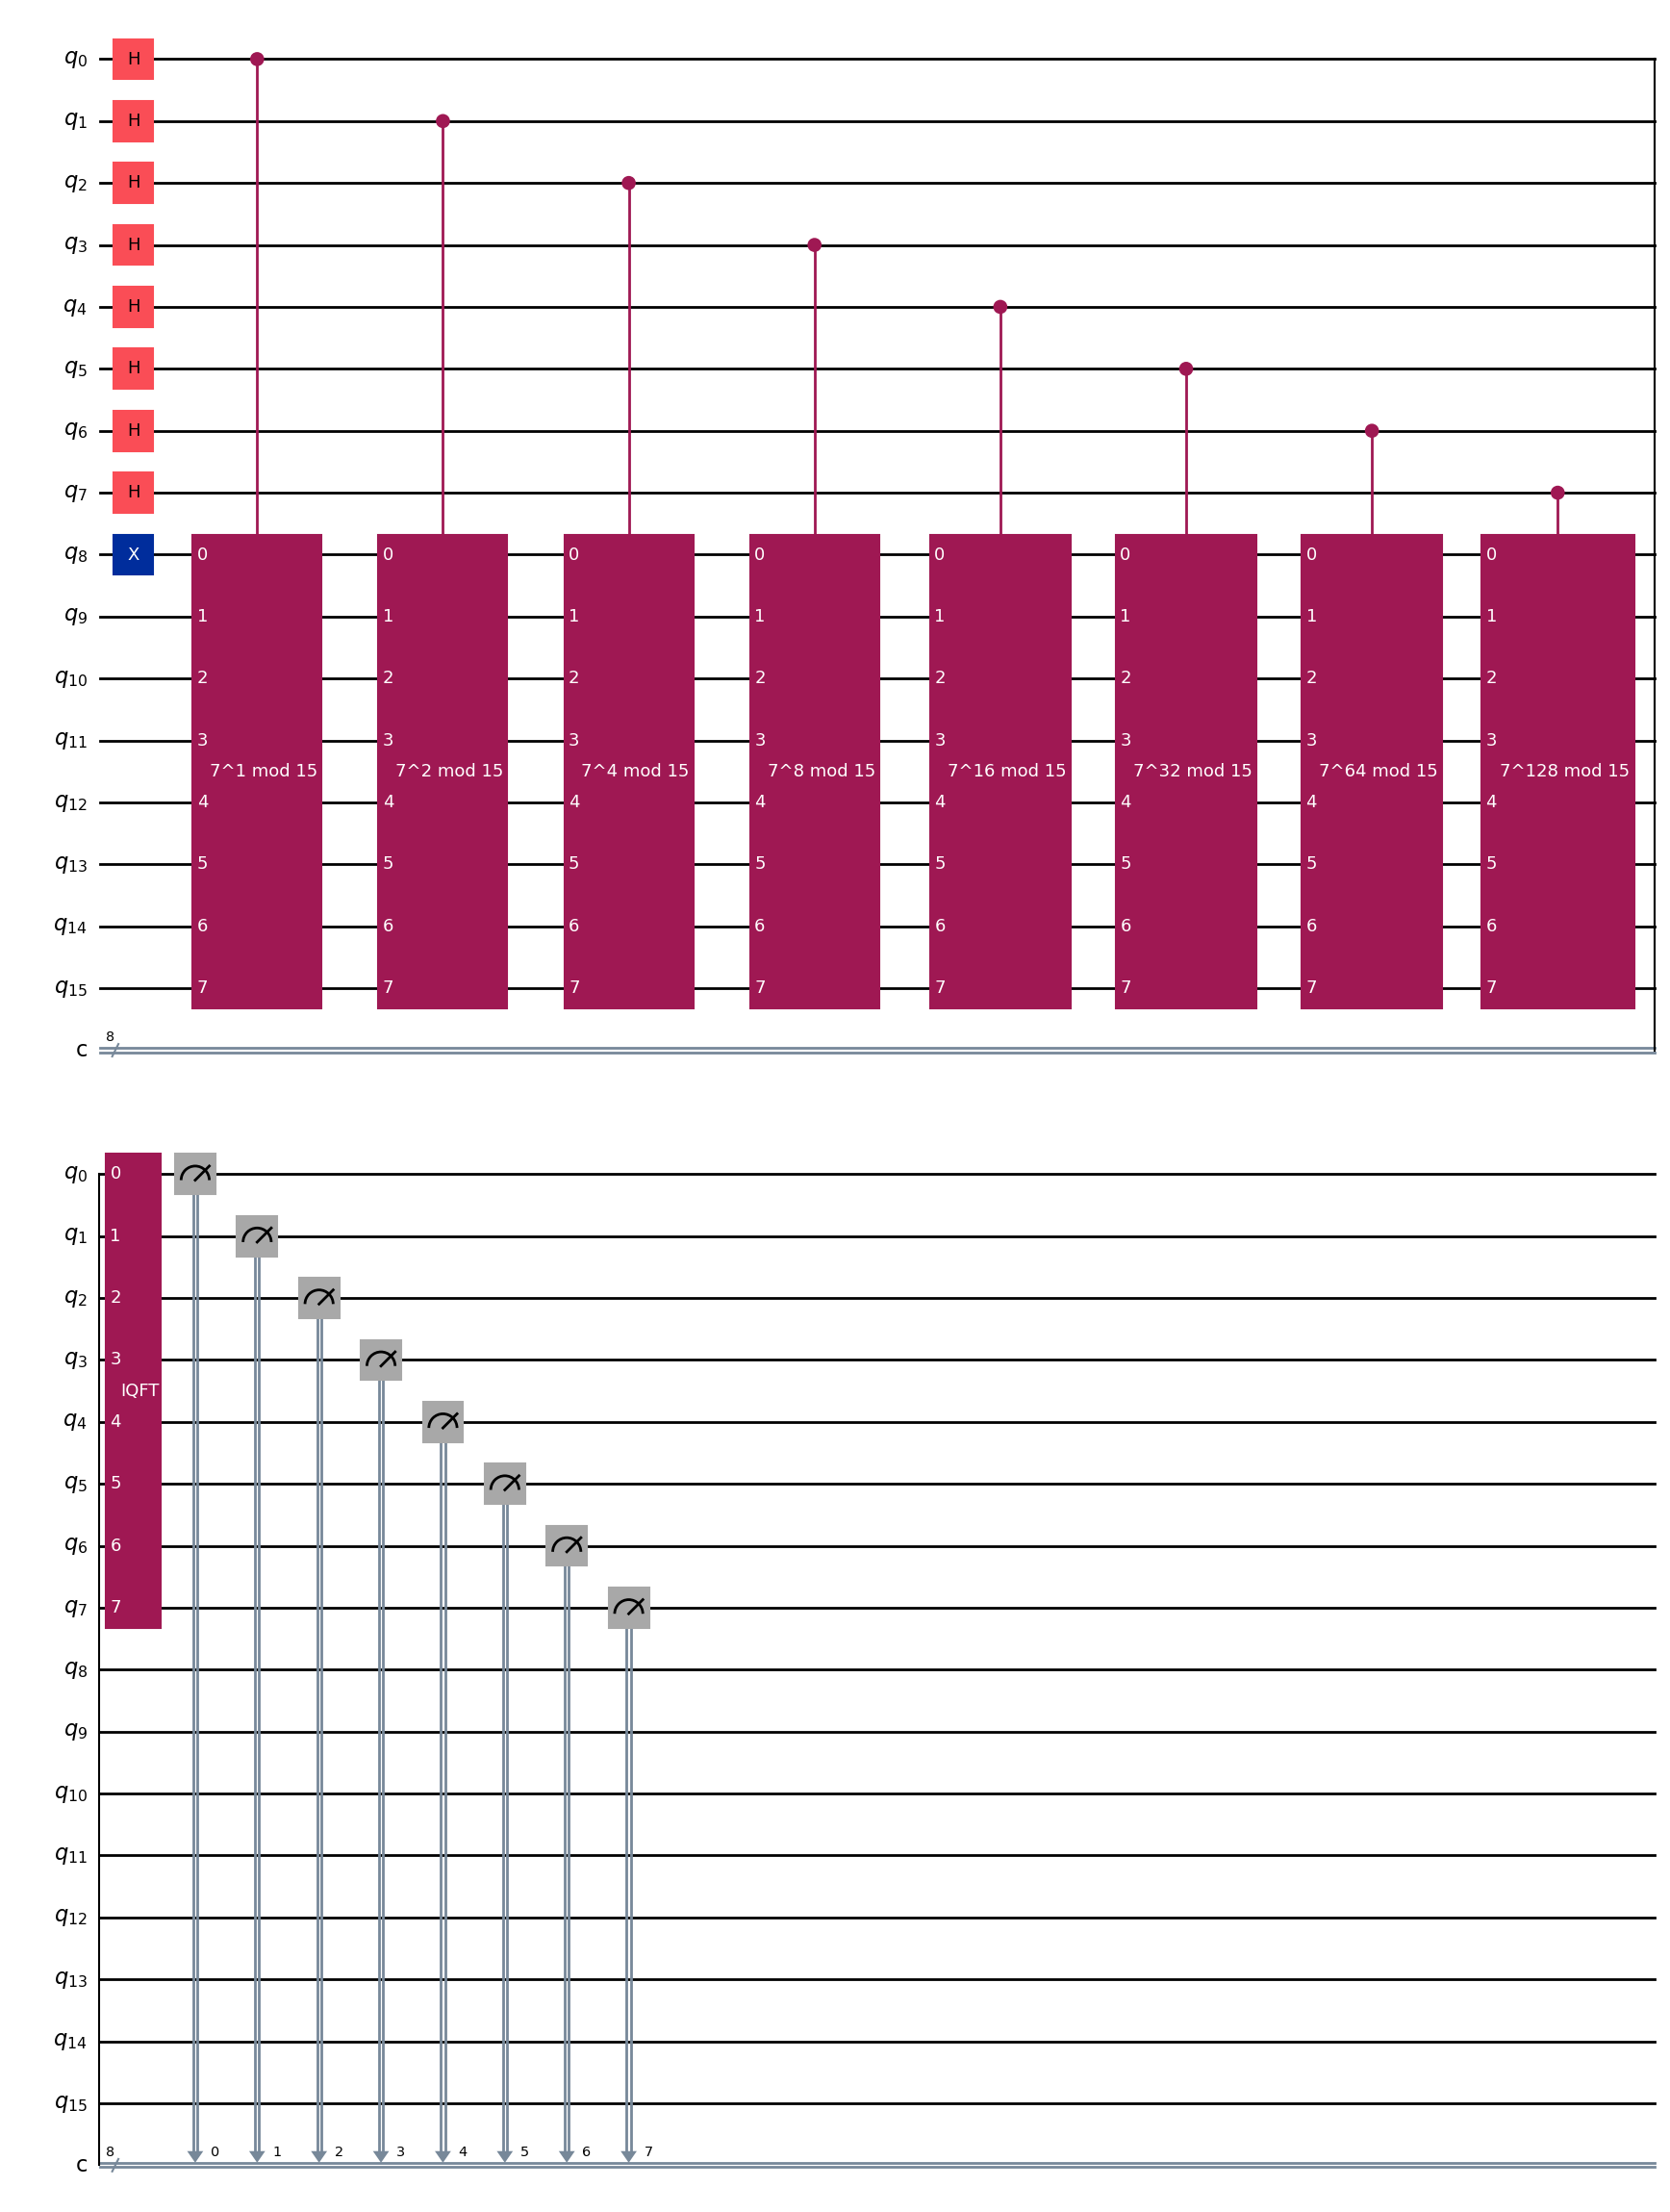

In [34]:
N=15 #prime factorising 15
a=7  #choose a random number coprime to N

def c_amod15(power):
    #Controlled modular multiplication by a^power mod 15
    U = QuantumCircuit(8)
    for _ in range(power % 8):
        U.swap(0, 1)
        U.swap(1, 2)
        U.swap(2, 3)
        U.swap(3, 4)
        U.swap(4, 5)
        U.swap(5, 6)
        U.swap(6, 7)
    return U.to_gate(label=f"{a}^{power} mod 15").control()

def construct_qpe_circuit(t_count=8):  #applying quantum phase estimation required to calculate the value of r(period)
    qc = QuantumCircuit(t_count + 8, t_count)

    # Apply Hadamard
    for i in range(t_count):
        qc.h(i)

    # Set the input state |1>
    qc.x(t_count + 0)

    # Apply controlled U^2^j gates
    for i in range(t_count):
        power = 2 ** i
        qc.append(c_amod15(power), [i] + [t_count + j for j in range(8)])

    # Apply inverse QFT
    qc.append(QFT(t_count, inverse=True, do_swaps=False), range(t_count))

    # Measure
    qc.measure(range(t_count), range(t_count))
    return qc

qc=construct_qpe_circuit()
qc.draw('mpl')

In [19]:
#simulating the circuit
from qiskit_aer import AerSimulator
from qiskit import transpile
sim = AerSimulator()
qc_transpiled = transpile(qc, sim)
job = sim.run(qc_transpiled, shots=100000)
result = job.result()
counts = result.get_counts()

In [26]:
from fractions import Fraction
import numpy as np
from math import gcd

def get_valid_r(counts, a, N, t_bits=6):

    sorted_counts = sorted(counts.items(), key=lambda x: -x[1])

    for measured_bin, _ in sorted_counts:
        phase = int(measured_bin, 2) / (2 ** t_bits)

        if phase == 0:
            continue  # skip zero, not useful

        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator

        if r % 2 != 0 or r == 0:
            continue  # we need even, non-zero r

        # check if r is valid: a^r ≡ 1 mod N
        if pow(a, r, N) == 1:
            print(phase)
            print(frac)
            return r

    return None  # no valid r found


t_bits = 8

r = get_valid_r(counts, a, N, t_bits)
print("the value of r is",r)

0.08203125
1/12
the value of r is 12


Now that we have got even r, we can factorise it as (a^r/2+1)*(a^r/2-1) which is divisible by N and hence at least one of them might share a common gcd with N which we can easily find Euclid's Division Lemma.

In [38]:
x=pow(a,r//2,N)
factor1=x-1;
factor2=x+1;
a1=gcd(factor1,N)
if(a1==N|a1==1):
  b=gcd(factor2,N)
  if(b==N|b==1):
    print("no factors found choose other a")
  else:
    print("factors of",N,"are",b,"and",int(N/b))
else:
  print("factors of",N,"are",a1,"and",int(N/a1))

factors of 15 are 3 and 5
